In [1]:
from collections import OrderedDict
from best.hVI_fsrm import SPaths
from best.hVI_fsrm import spec_Spaths
from best.hVI_models import State_Space, Det_SI_Model
from best.hVI_types import Env, Gamma
import best.rss18_functions as rf
from best.hVI_config import sc, load, parr, obs_action, epsilon, rand_seed
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import copy
import cPickle as pkl
import random
from os import fork
from joblib import Parallel, delayed
import multiprocessing
from itertools import product
import time

from polytope import *
%matplotlib inline

No handlers could be found for logger "polytope.solvers"


In [2]:
import sys
sys.version[0]

'2'

In [3]:
print "Setting Up Scenario"

# Define Regions
# Regs have the same format as RSS code. Regs that are added first have a higher priority
#### Wall region
print("Started wall case")
regs = OrderedDict()
p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, 1], [2, 1]]))
regs['r1'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, 1], [3, 1], [3, 2], [2, 2]]))
regs['r2'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, 2], [3, 2], [3, 3], [2, 3]]))
regs['r3'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, 3], [3, 3], [3, 4], [2, 4]]))
regs['r4'] = (p4, .6, 'obs', 1)
p5 = rf.vertex_to_poly(np.array([[2, 4], [3, 4], [3, 5], [2, 5]]))
regs['r5'] = (p5, .6, 'obs', 0)

p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, -1], [2, -1]]))
regs['r6'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, -1], [3, -1], [3, -2], [2, -2]]))
regs['r7'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, -2], [3, -2], [3, -3], [2, -3]]))
regs['r8'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, -3], [3, -3], [3, -4], [2, -4]]))
regs['r9'] = (p4,1, 'obs', 0)
p5 = rf.vertex_to_poly(np.array([[2, -4], [3, -4], [3, -5], [2, -5]]))
regs['r10'] = (p5, .9, 'obs', 0)

a1 = rf.vertex_to_poly(np.array([[4, 0], [5, 0], [5, 1], [4, 1]]))
regs['a1'] = (a1, 0.9, 'sample1', 1)

a2 = rf.vertex_to_poly(np.array([[4, -3], [5, -3], [5, -2], [4, -2]]))
regs['a2'] = (a2, 0.1, 'sample2', 1)

output_color = {'r1': 'red', 'r2': 'red', 'r3': 'red', 'r4': 'red', 'r5': 'red', 'r6': 'red', 'r7': 'red',
                'r8': 'red', 'r9': 'red', 'r10': 'red',
                'a1': 'green','a2': 'blue', 'null': 'white'}
# Define Null regions with bounds of the space for null output with lowest priority
p = rf.vertex_to_poly(np.array([[-3, -5], [-3, 5], [5, -5], [5, 5]]))
regs['null'] = (p, 1.0, 'null')

# Construct belief-MDP for env
env = Env(regs)
print(env)

Setting Up Scenario
Started wall case
Regions: 
OrderedDict([('r4', 0), ('r5', 1), ('r10', 2), ('a1', 3), ('a2', 4)])

Total number of unknown regions: 5
Total number of  regions: 13


 Setup Motion and Observation Models 
 The used model contains an integrator for each dimension:

[[1. 0.]
 [0. 1.]]
 Constructing FIRM
[[1. 0.]
 [0. 1.]]
[[0.1 0. ]
 [0.  0.1]]
[[10.51249  0.     ]
 [ 0.      10.51249]]
('remove edge', set([4, 5]))
set(['r4', 'r5', 'null'])
('remove edge', set([4, 37]))
set(['r4', 'null', 'r3'])
('remove edge', set([29, 6]))
set(['null', 'r10'])
('remove edge', set([10, 12]))
set(['a2', 'null', 'r9', 'r10'])
('remove edge', set([35, 37]))
set(['null', 'r1'])
[0.05304 1.11723]
0.066559


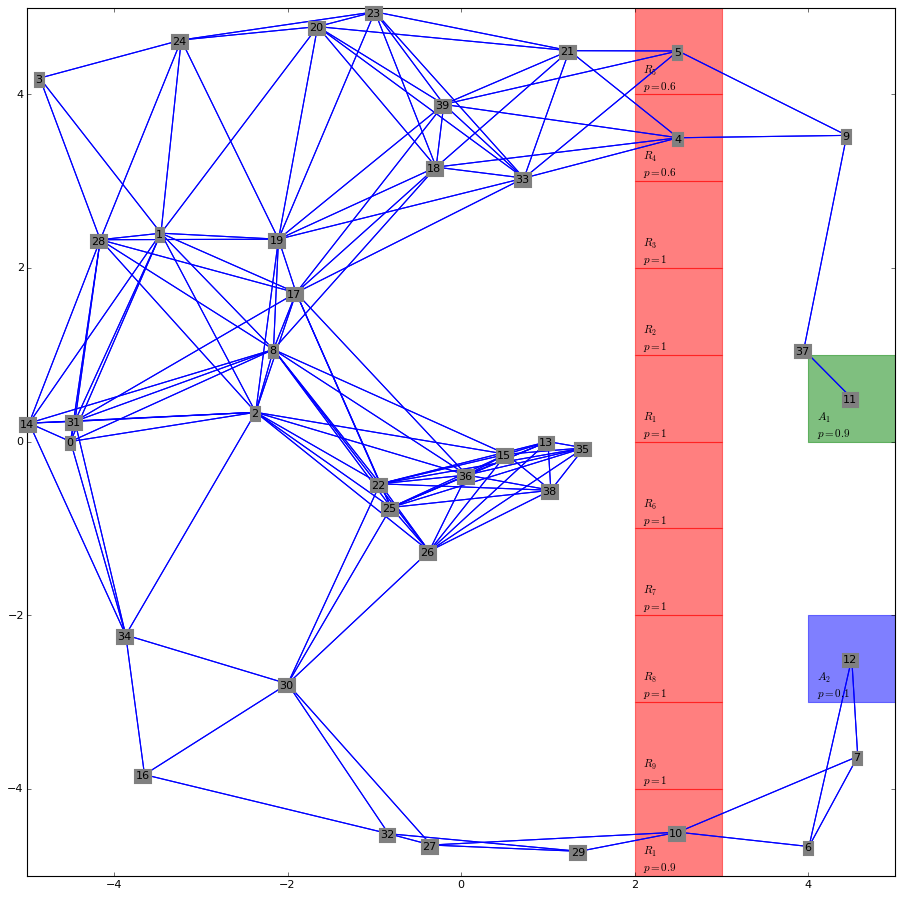

In [4]:
''' Configuration Parameters '''
random.seed(rand_seed)
np.random.seed(rand_seed)

print ''' Setup Motion and Observation Models '''
# Define Motion and Observation Model
Wx = np.eye(2)
Wu = np.eye(2)
r2_bs = State_Space([-5, -5], [5, 5])
motion_model = Det_SI_Model(0.1)

print " Constructing FIRM"
fig = plt.figure(figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, aspect='equal')
firm = SPaths(r2_bs, motion_model, Wx, Wu, regs, output_color, ax)
firm.make_nodes_edges(40, 3, init=np.array([[-4.5],[0]]))
t1 = time.clock()
firm.compute_output_prob()
t2 = time.clock()
firm.plot(ax)
# plt.show()

print(t2-t1)


In [5]:
print('-- Generate the DFA and the Product model c')
from best.fsa import Fsa
props = ['obs', 'sample1', 'sample2']
props = dict(zip(props, map(lambda x: 2 ** x, range(0, len(props)))))
print(props)
fsa = Fsa()
vars(Fsa)
fsa.g.add_node('0')
fsa.g.add_node('trap')
fsa.g.add_node('1')

fsa.g.add_edge('0','1', weight=0, input={props['sample1'],props['sample2'],props['sample2']+props['sample1']})
fsa.g.add_edge('0','0', weight=0, input={0})


fsa.g.add_edge('0','trap', weight=0, input={props['obs']})

fsa.props=props
fsa.final = {'1'}
fsa.init = dict({'0':1})

#fsa.g.add_edge(src, dest, weight=0, input=bitmaps, guard=guard, label=guard)
from best.ltl import formula_to_mdp

fsaform = Fsa()
form = '! obs U sample'
fsaform.from_formula(form)
vars(fsa.g)
print(fsaform.g.edges(data=True))
formula_fsa = dict()
formula_fsa['fsa'] = fsa
formula_fsa['init'] = dict({'0':1})
formula_fsa['final'] = {'1'}
formula_fsa['prop'] = props

env.get_prop('r3')
prod_ =spec_Spaths(firm, formula_fsa,env,n=125)


-- Generate the DFA and the Product model c
{'sample1': 2, 'obs': 1, 'sample2': 4}
[(u'1', u'1', {'input': set([0, 1, 2, 3]), 'guard': '(1)', 'weight': 0, 'label': '(1)'}), (u'0', u'1', {'input': set([1, 3]), 'guard': u'sample', 'weight': 0, 'label': u'sample'}), (u'0', u'0', {'input': set([0]), 'guard': u'(!sample & !obs)', 'weight': 0, 'label': u'(!sample & !obs)'})]
Added virtual final node = (-1, -1)
adding edge to target
adding edge to target
('visited', [(-1, -1), ('1', 11), ('1', 12), ('0', 37), ('0', 6), ('0', 7), ('0', 11), ('0', 9), ('0', 10), ('0', 12), ('0', 5), ('0', 4), ('0', 29), ('0', 27), ('0', 21), ('0', 33), ('0', 39), ('0', 18), ('0', 32), ('0', 30), ('0', 20), ('0', 23), ('0', 19), ('0', 17), ('0', 8), ('0', 16), ('0', 34), ('0', 26), ('0', 22), ('0', 25), ('0', 24), ('0', 1), ('0', 2), ('0', 28), ('0', 36), ('0', 31), ('0', 0), ('0', 14), ('0', 15), ('0', 13), ('0', 35), ('0', 38), ('0', 3)])


In [6]:
import matplotlib.pyplot as plt


def plot_bel(n,i):
    print(prod_.env.b_reg_init.tolist())
    
    (q,v) =  n
    vals = []
    for b_i in np.linspace(0,1,20):
        b_ind = [ prob if not el == i else [b_i]  for el,prob in enumerate(prod_.env.b_reg_init.tolist()) ]
        b = prod_.env.get_product_belief(b_ind)
        vals += [max(prod_.val[(q,v)].alpha_mat.T * b).tolist()]
    plt.figure(0)

    plt.plot(np.linspace(0,1,20),sum(vals,[]))
    plt.ylabel('some numbers')
    ax = plt.gca()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.show()

    



In [7]:
print('Start Back-ups')

not_converged = True
i = 0
(q,key) = prod_.init[0]
n = (q,20) 
opts =dict()
while not_converged:
    print('iteration', i)
    not_converged = prod_.full_back_up(opts)
    #plot_bel(n,0)
    #opt = np.unique(prod_.val[n].best_edge) 
    #print(opt)
    if i>30:
        not_converged = False
#     else:
#         not_converged = True
    i += 1

Start Back-ups
('iteration', 0)
Do full back-up
7.160622
('iteration', 1)
Do full back-up
('converged', ('0', 37))
('converged', ('0', 6))
('converged', ('0', 7))
('converged', ('0', 11))
('converged', ('0', 9))
('converged', ('0', 10))
('converged', ('0', 12))
('converged', ('0', 5))
('converged', ('0', 4))
('converged', ('0', 29))
('converged', ('0', 27))
('converged', ('0', 32))
7.838266
('iteration', 2)
Do full back-up
('converged', ('0', 5))
('converged', ('0', 4))
5.958951
('iteration', 3)
Do full back-up
5.784321
('iteration', 4)
Do full back-up
6.402873
('iteration', 5)
Do full back-up
7.042141
('iteration', 6)
Do full back-up
8.015294
('iteration', 7)
Do full back-up
7.15213
('iteration', 8)
Do full back-up
7.395115
('iteration', 9)
Do full back-up
('converged', ('0', 6))
('converged', ('0', 7))
('converged', ('0', 12))
7.212684
('iteration', 10)
Do full back-up
('converged', ('0', 6))
('converged', ('0', 7))
7.135439
('iteration', 11)
Do full back-up
('converged', ('0', 6))
(

In [8]:
for region, el in prod_.env.reg_index.items():
    print("{r} has probability  {p}".format(p= prod_.env.b_reg_init[el].tolist()[0][0], r=region ))

r4 has probability  0.6
r5 has probability  0.6
r10 has probability  0.9
a1 has probability  0.9
a2 has probability  0.1


In [38]:
prod_.init = [('0',0,)]
from copy import copy
def plot_results(prod,ax):
    '''
    Give a plot of the optimizers of the current graph.
    Based on the firm graph, but nodes now include also info on the state of the DFA
    :param prod: product of DFA and FIRM
    :type prod: spec_Spaths
    :return:
    '''
    # TODO TODO FiniSH WHERE I STOPPED CODING >>> make sure to only plot directed edges for possible optimal actions.
    # build the nodes from the once that are actually reachable:
    # start from the initial node
    nodes = dict()  # empty dict with nodes as keys and values: (x,y),
    obs = dict()   #  empty dict with nodes as keys, values: set of obs actions
    edges = set()  # empty set with elements (x1,y1,x2,y2) with node from   (x1,y1)  and node to (x2,y2)
     # list of nodes for which edges needs to be accounted for, initialized with
                        # a list of initial node tuples (i_q, i_v)
    unvisited = copy(prod.init)
    visited = []
    while unvisited:
        n = unvisited.pop(0)
        visited += [n]
        (i_q, i_v) = n
        opt = np.unique(prod.val[(i_q, i_v)].best_edge) 
        # split into obs actions and transitions actions
        obs_actions  = filter(lambda i: i<0, opt) # decide to observe a neigborhood
        tr_actions  = filter(lambda i: i>=0, opt) # decide to transition to a new node
        # find (x,y)
        x = np.ravel(prod.firm.nodes[i_v].mean)[0]
        y = np.ravel(prod.firm.nodes[i_v].mean)[1]
        nodes[i_v] = (x,y)
        obs[i_v] = obs.get(i_v,set())|set(obs_actions)
        edges |= {(i_v,i_next) for i_next in tr_actions}
        # to find the nodes (composed of i_q,i_v) that have not yet been added and
        # that are accessible from this node based ont he transition actions, check transitions in prod

        for n_next in prod[n]:
            if n_next[1] in tr_actions:
                if (not n_next in unvisited) and (not n_next in visited):
                    unvisited.extend([(n_next)])
        for i_v in nodes:
            if i_v < 10:
                plt.text(nodes[i_v][0] - 0.04, nodes[i_v][1] - 0.05, str(i_v),
                         color='black', backgroundcolor='grey')
            else:
                plt.text(nodes[i_v][0] - 0.09, nodes[i_v][1] - 0.05, str(i_v),
                         color='black', backgroundcolor='grey')
    for (start,dest) in edges:
            plt.plot([nodes[start][0],nodes[dest][0]],[nodes[start][1],nodes[dest][1]],color='black')

            plt.arrow(nodes[start][0],nodes[start][1],.7*(nodes[dest][0]-nodes[start][0]),.7*(nodes[dest][1]-nodes[start][1]), head_width=0.2, head_length=.2, fc='k', ec='k')



    print('Nodes that can be pruned: {n}'.format(n=sorted(filter(lambda i: not i[1] in nodes, prod.nodes))))
    ax.set_xlim(prod.firm.state_space.x_low[0], prod.firm.state_space.x_up[0])
    ax.set_ylim(prod.firm.state_space.x_low[1], prod.firm.state_space.x_up[1])
    print('number of active nodes = {n}, percent of orig. nodes = {o} %'.format(n=len(nodes),o=100*len(nodes.keys())/len(prod.nodes)))
    print('number of active edges = {n}, percent of orig. edges = {o} %'.format(n=len(edges),o=100*len(edges)/len(prod.edges),))


        


Nodes that can be pruned: [(-1, -1), ('0', 3), ('0', 13), ('0', 14), ('0', 15), ('0', 23), ('0', 24), ('0', 28), ('0', 31), ('0', 35), ('0', 36), ('0', 38)]
number of active nodes = 29, percent of orig. nodes = 63 %
number of active edges = 97, percent of orig. edges = 32 %


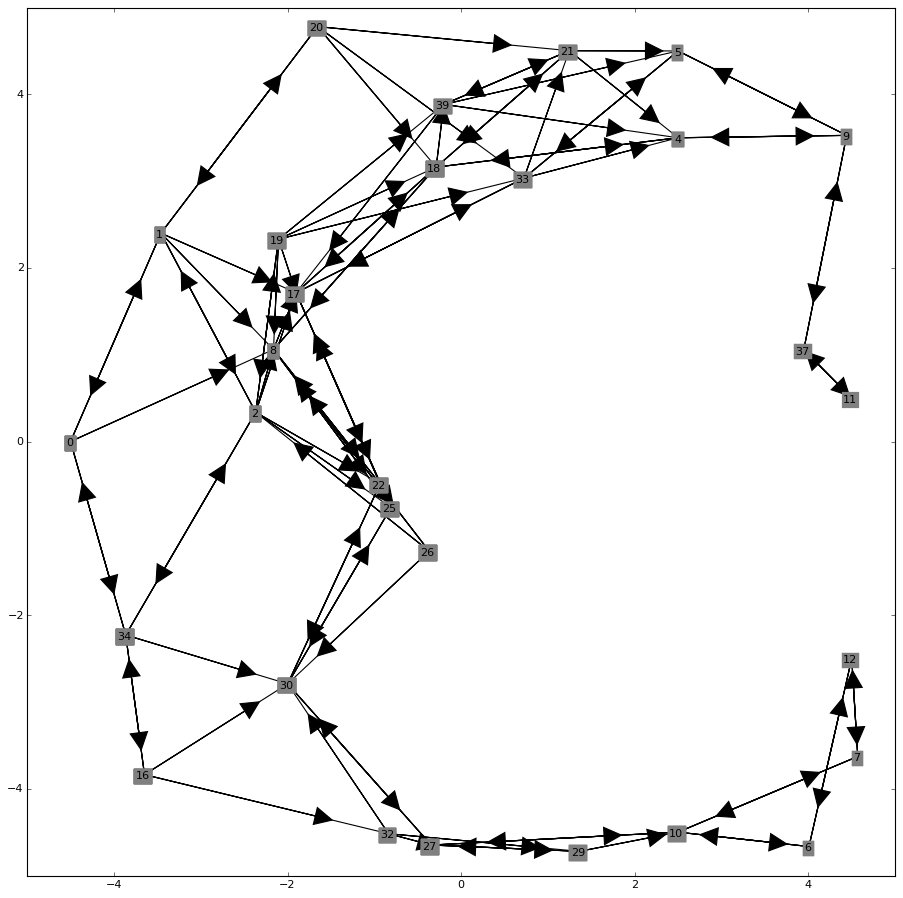

In [40]:
fig = plt.figure(figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, aspect='equal')

plot_results(prod_,ax)

In [41]:
''' Execute the policy '''
b = prod_.env.b_prod_init
plt.figure()
print b
(q,key) = prod_.fsa.init.items()[0]
(q,v) = (q,0)
# v = 0
traj = []
v_list =[v]
act_list =[]
vals = []
for t in range(150):
    # import pdb; pdb.set_trace()
    #print((q,v))
    #print(prod_.val[(q,v)].alpha_mat.T * np.array(b))
    #print "val = " + str(max(prod_.val[(q,v)].alpha_mat.T * b))
    #vals += [str(max(prod_.val[(q,v)].alpha_mat.T * b))]
    # Get best edge
    alpha_new, best_e, opt = prod_._back_up(q, v, b)
    # print("best action = ",best_e)
    vals += [opt]
#     i_best_alpha = np.argmax(prod_.val[(q,v)].alpha_mat.T * b)
#     best_e = prod_.val[(q,v)].best_edge[i_best_alpha]

    if obs_action is True and best_e < 0:
        reg_key = prod_.env.regs.keys()[-1 * (best_e + 1)]
        (b_, o, i_o) = env.get_b_o_reg(b, env.regs[reg_key][3], reg_key, prod_.firm.nodes[v].mean)
        b = b_
        act_list += ["Observing = " +reg_key ]
        print "Observing " +reg_key + " at vertex" + str(v) + " q = " + str(q) 
        continue
    # Simulate trajectory under edges
    edge_controller = firm.edge_controllers[v][firm.edges[v].index(best_e)]
    traj_e = edge_controller.simulate_trajectory(edge_controller.node_i)
    traj_n = firm.node_controllers[firm.nodes.index(edge_controller.node_j)].simulate_trajectory(traj_e[-1])
    # traj_i = [(b, i, q) for i in traj_e + traj_n]
    traj_i = traj_e + traj_n
    traj = traj + traj_i
    # Get q', v', q' and loop
    z = firm.get_output_traj(traj_e + traj_n)
    v_ = best_e
    act_list += [best_e]

    if obs_action is False:
        print "TODO: Implement backup without obs_action"
    else:
        if regs[z][2] is 'null':
            b_ = b
            q_ = q
        elif regs[z][2] is 'obs' or regs[z][2] is 'sample1':
            q_ = None
            b_ = None
            # if region is known
            if regs[z][1] == 1 or regs[z][1] == 0:
                # if label is true
                if regs[z][1] == 1:
                    q_ = prod_.fsa.next_states_of_fsa(q,regs[z][2]) 
                    b_ = b
            # else update belief by simulating an observation
            else:
                (b_, o, i_o) = env.get_b_o_reg(b, env.regs[z][3], z)
                # if true label is true then do transition in DFA
                # We are assuming that we get zero false rate when we pass through the region
                #print(regs[z][2], i_o)
                if regs[z][3] is 1:
                    #print(regs[z][2], regs[z][3])
                    q_ = prod_.fsa.next_states_of_fsa(q,(env.regs[z][2],)) 
            if q_ is None:
                q_ = q
            if b_ is None:
                b_ = b
    print "going from vertex " + str(v) + " to vertex " + str(v_) + " q = " + str(q)

    b = b_
    q = q_
    v = v_
    v_list += [v]
    if q in list(prod_.dfsa_final) or q == list(prod_.dfsa_final):
        print('break')
        break
print(v_list)
print(vals)
print(act_list)
prod_.firm.plot_traj(traj, 'green')


[[0.00144]
 [0.00216]
 [0.00216]
 [0.00324]
 [0.01296]
 [0.01944]
 [0.01944]
 [0.02916]
 [0.01296]
 [0.01944]
 [0.01944]
 [0.02916]
 [0.11664]
 [0.17496]
 [0.17496]
 [0.26244]
 [0.00016]
 [0.00024]
 [0.00024]
 [0.00036]
 [0.00144]
 [0.00216]
 [0.00216]
 [0.00324]
 [0.00144]
 [0.00216]
 [0.00216]
 [0.00324]
 [0.01296]
 [0.01944]
 [0.01944]
 [0.02916]]
going from vertex 0 to vertex 1 q = 0
going from vertex 1 to vertex 20 q = 0
going from vertex 20 to vertex 21 q = 0
Observing r5 at vertex21 q = 0
Observing r5 at vertex21 q = 0
going from vertex 21 to vertex 5 q = 0
going from vertex 5 to vertex 9 q = 0
going from vertex 9 to vertex 37 q = 0
going from vertex 37 to vertex 11 q = 0
break
[0, 1, 20, 21, 5, 9, 37, 11]
[0.5276100255897135, 0.5329394197875893, 0.5383226462500903, 0.543743645341576, 0.8313592684740657, 0.8640008599313894, 0.8741378458127691, 0.8829675210229988, 0.891886384871716]
[1, 20, 21, 'Observing = r5', 'Observing = r5', 5, 9, 37, 11]
